# Credit Card Fraud Detection System
## End-to-End Machine Learning Pipeline

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, precision_recall_curve,
    f1_score, precision_score, recall_score, average_precision_score
)

# Model persistence
import joblib
import pickle

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
df = pd.read_csv('card_transdata.csv')  # Replace with your actual file path

print(f"Dataset Shape: {df.shape}")
print(f"\n{'='*50}")
print("First Few Rows:")
print(df.head())

Dataset Shape: (1000000, 8)

First Few Rows:
   distance_from_home  distance_from_last_transaction  \
0           57.877857                        0.311140   
1           10.829943                        0.175592   
2            5.091079                        0.805153   
3            2.247564                        5.600044   
4           44.190936                        0.566486   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        1.945940              1.0        1.0   
1                        1.294219              1.0        0.0   
2                        0.427715              1.0        0.0   
3                        0.362663              1.0        1.0   
4                        2.222767              1.0        1.0   

   used_pin_number  online_order  fraud  
0              0.0           0.0    0.0  
1              0.0           0.0    0.0  
2              0.0           1.0    0.0  
3              0.0           1.0    0.0  
4          

In [3]:
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [4]:
print("\nDataset Description:")
df.describe()


Dataset Description:


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64


In [6]:
print("\nData Types:")
print(df.dtypes)


Data Types:
distance_from_home                float64
distance_from_last_transaction    float64
ratio_to_median_purchase_price    float64
repeat_retailer                   float64
used_chip                         float64
used_pin_number                   float64
online_order                      float64
fraud                             float64
dtype: object


Fraud Distribution:
fraud
0.0    912597
1.0     87403
Name: count, dtype: int64


Fraud Percentage:
fraud
0.0    91.2597
1.0     8.7403
Name: proportion, dtype: float64

Imbalance Ratio: 1:10.44
This means for every 1 fraudulent transaction, there are 10.44 legitimate ones.


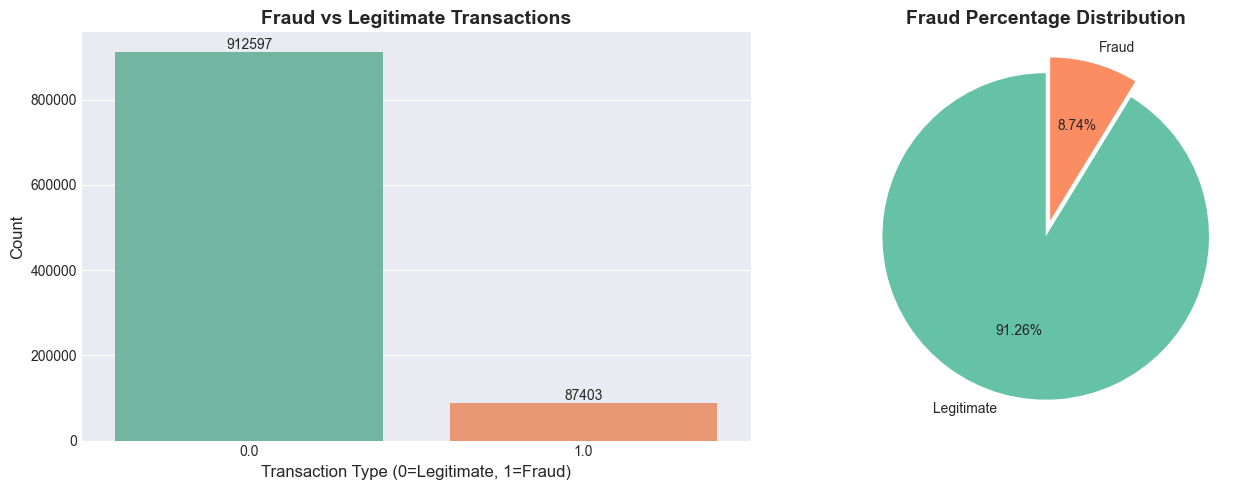

In [7]:
fraud_counts = df['fraud'].value_counts()
fraud_percentage = df['fraud'].value_counts(normalize=True) * 100

print("Fraud Distribution:")
print(fraud_counts)
print(f"\n{'='*50}")
print("\nFraud Percentage:")
print(fraud_percentage)

imbalance_ratio = fraud_counts[0] / fraud_counts[1]
print(f"\n{'='*50}")
print(f"Imbalance Ratio: 1:{imbalance_ratio:.2f}")
print(f"This means for every 1 fraudulent transaction, there are {imbalance_ratio:.2f} legitimate ones.")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(data=df, x='fraud', ax=axes[0], palette='Set2')
axes[0].set_title('Fraud vs Legitimate Transactions', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Transaction Type (0=Legitimate, 1=Fraud)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
for container in axes[0].containers:
    axes[0].bar_label(container)

colors = ['#66c2a5', '#fc8d62']
axes[1].pie(fraud_counts, labels=['Legitimate', 'Fraud'], autopct='%1.2f%%', 
            colors=colors, startangle=90, explode=(0, 0.1))
axes[1].set_title('Fraud Percentage Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

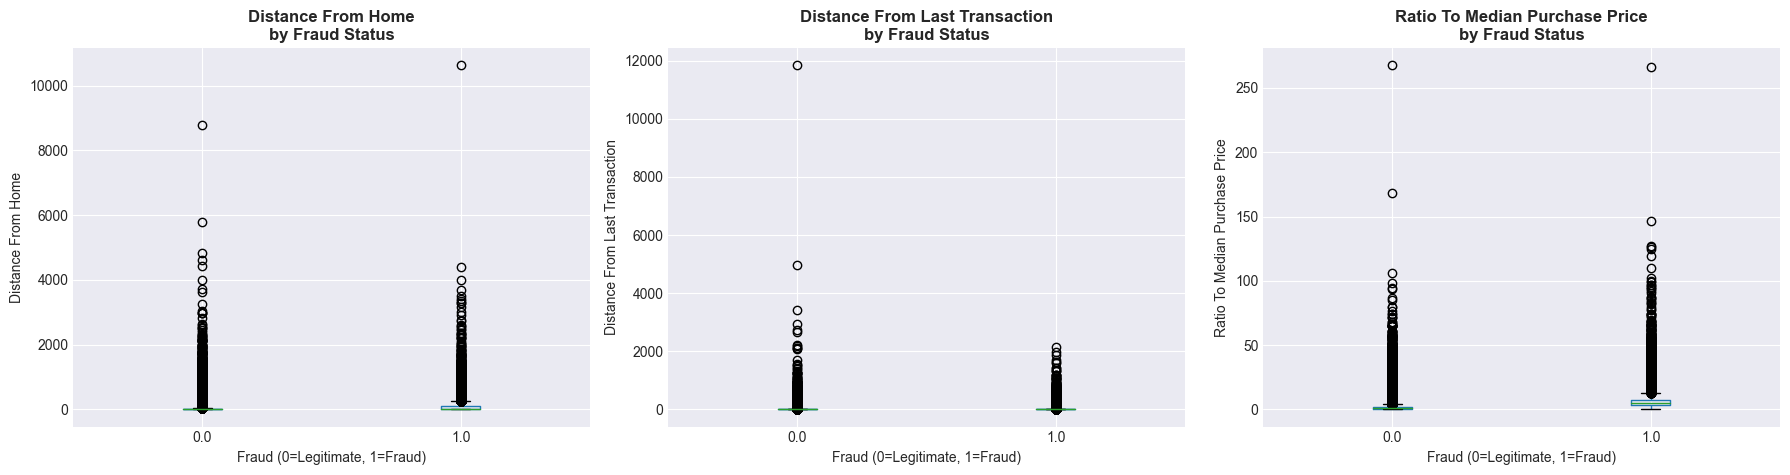

In [8]:
numerical_cols = ['distance_from_home', 'distance_from_last_transaction', 
                  'ratio_to_median_purchase_price']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col in enumerate(numerical_cols):
    # Box plot
    df.boxplot(column=col, by='fraud', ax=axes[idx])
    axes[idx].set_title(f'{col.replace("_", " ").title()}\nby Fraud Status', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Fraud (0=Legitimate, 1=Fraud)', fontsize=10)
    axes[idx].set_ylabel(col.replace("_", " ").title(), fontsize=10)

plt.suptitle('')  # Remove the default title
plt.tight_layout()
plt.show()

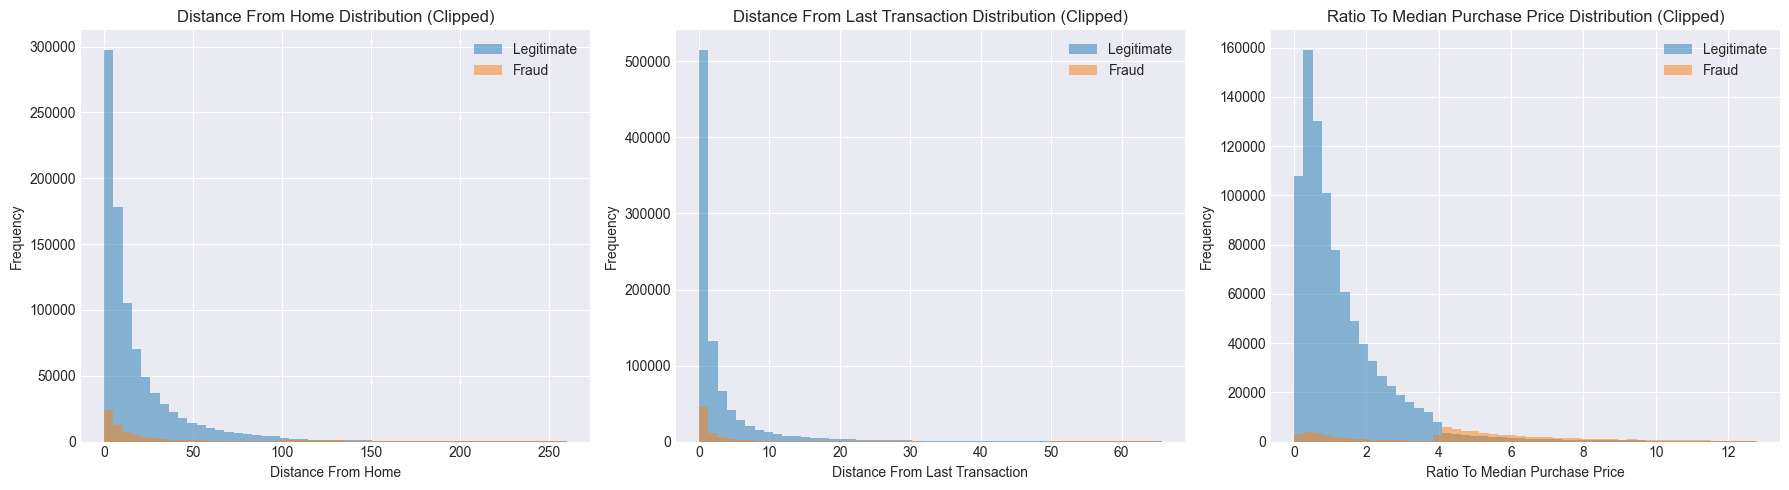

In [9]:
from numpy import percentile

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col in enumerate(numerical_cols):
    upper = percentile(df[col], 99)  

    df_clip = df[df[col] <= upper]

    axes[idx].hist(df_clip[df_clip['fraud']==0][col], bins=50, alpha=0.5, label='Legitimate')
    axes[idx].hist(df_clip[df_clip['fraud']==1][col], bins=50, alpha=0.5, label='Fraud')

    axes[idx].set_title(f'{col.replace("_", " ").title()} Distribution (Clipped)')
    axes[idx].set_xlabel(col.replace("_", " ").title())
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()

plt.tight_layout()
plt.show()


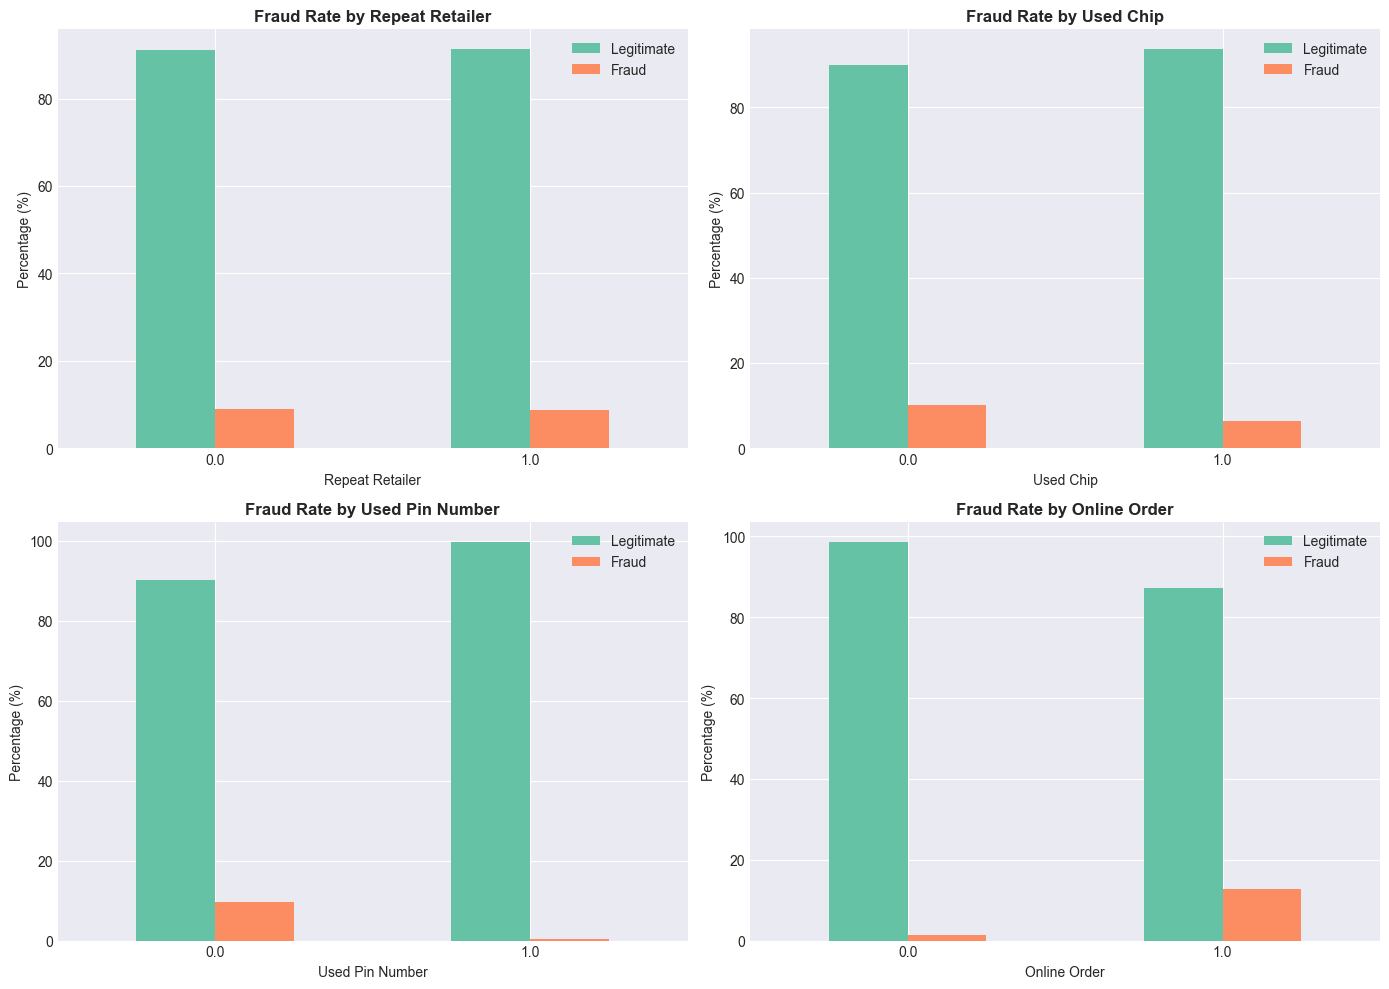

In [10]:
# Categorical features
categorical_cols = ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, col in enumerate(categorical_cols):
    # Crosstab
    ct = pd.crosstab(df[col], df['fraud'], normalize='index') * 100
    ct.plot(kind='bar', ax=axes[idx], color=['#66c2a5', '#fc8d62'])
    axes[idx].set_title(f'Fraud Rate by {col.replace("_", " ").title()}', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col.replace("_", " ").title(), fontsize=10)
    axes[idx].set_ylabel('Percentage (%)', fontsize=10)
    axes[idx].legend(['Legitimate', 'Fraud'])
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

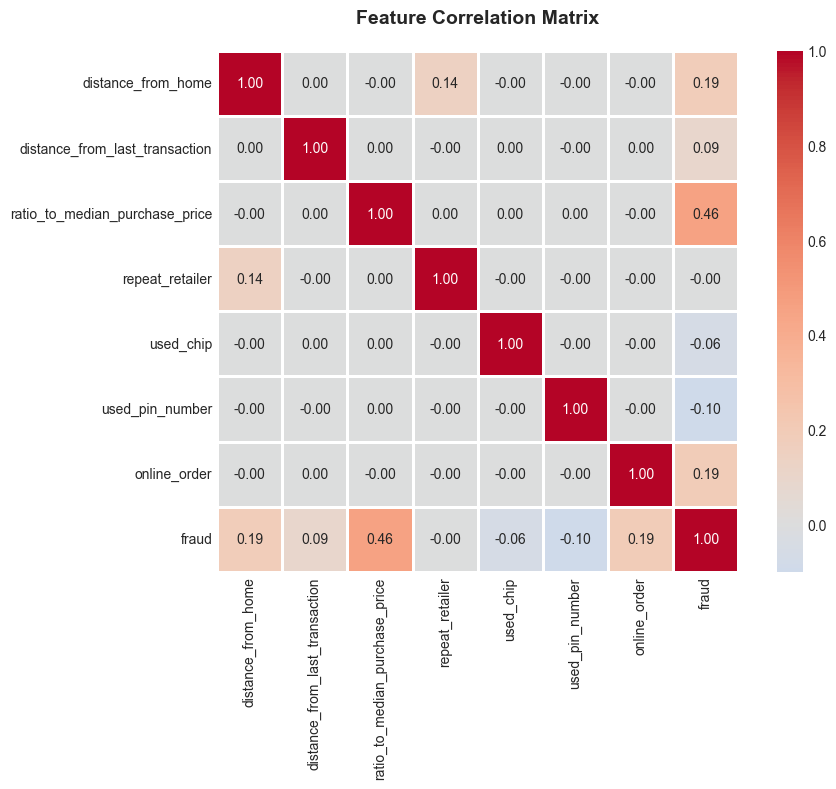


Correlation with Fraud:
fraud                             1.000000
ratio_to_median_purchase_price    0.462305
online_order                      0.191973
distance_from_home                0.187571
distance_from_last_transaction    0.091917
repeat_retailer                  -0.001357
used_chip                        -0.060975
used_pin_number                  -0.100293
Name: fraud, dtype: float64


In [11]:
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.2f')
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Correlation with target
print("\nCorrelation with Fraud:")
print(df.corr()['fraud'].sort_values(ascending=False))

In [12]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to create engineered features.
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        # Transaction velocity
        X_copy['transaction_velocity'] = (
            X_copy['distance_from_last_transaction'] / 
            (X_copy['distance_from_last_transaction'].mean() + 1)
        )
        
        # Home distance risk
        X_copy['home_distance_risk'] = pd.cut(
            X_copy['distance_from_home'], 
            bins=[0, 50, 100, 200, float('inf')],
            labels=[0, 1, 2, 3]
        ).astype(int)
        
        # Purchase anomaly
        X_copy['purchase_anomaly'] = (
            X_copy['ratio_to_median_purchase_price'] > 3
        ).astype(int)
        
        # Security level
        X_copy['security_level'] = (
            X_copy['used_chip'] + X_copy['used_pin_number']
        )
        
        # Interaction features
        X_copy['online_no_chip'] = (
            (X_copy['online_order'] == 1) & (X_copy['used_chip'] == 0)
        ).astype(int)
        
        X_copy['high_amount_far_home'] = (
            (X_copy['ratio_to_median_purchase_price'] > 2) & 
            (X_copy['distance_from_home'] > 100)
        ).astype(int)
        
        return X_copy


# Custom transformer for outlier handling
class OutlierHandler(BaseEstimator, TransformerMixin):
    """
    Handle outliers using IQR method.
    """
    def __init__(self, method='iqr', threshold=1.5):
        self.method = method
        self.threshold = threshold
        self.bounds = {}
    
    def fit(self, X, y=None):
        numerical_cols = X.select_dtypes(include=[np.number]).columns
        
        for col in numerical_cols:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - self.threshold * IQR
            upper_bound = Q3 + self.threshold * IQR
            self.bounds[col] = (lower_bound, upper_bound)
        
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        for col, (lower, upper) in self.bounds.items():
            X_copy[col] = X_copy[col].clip(lower=lower, upper=upper)
        
        return X_copy


print(" Custom transformer classes created successfully!")

 Custom transformer classes created successfully!


In [13]:
X = df.drop('fraud', axis=1)
y = df['fraud']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

In [15]:
print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTarget distribution in training set:")
print(y_train.value_counts())
print(f"\nTarget distribution in test set:")
print(y_test.value_counts())


Training set size: (800000, 7)
Test set size: (200000, 7)

Target distribution in training set:
fraud
0.0    730078
1.0     69922
Name: count, dtype: int64

Target distribution in test set:
fraud
0.0    182519
1.0     17481
Name: count, dtype: int64


In [16]:
feature_engineer = FeatureEngineer()
outlier_handler = OutlierHandler(threshold=3.0)
scaler = RobustScaler()
sampler = SMOTE(random_state=RANDOM_STATE, sampling_strategy=0.5)

models = {
    'Logistic Regression': LogisticRegression(
        random_state=RANDOM_STATE, 
        max_iter=1000,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        max_depth=10,
        min_samples_split=10,
        class_weight='balanced',
        n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        max_depth=5,
        learning_rate=0.1,
        scale_pos_weight=10,
        eval_metric='logloss'
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        max_depth=5,
        learning_rate=0.1,
        class_weight='balanced',
        verbosity=-1
    )
}

pipelines = {}
for name, model in models.items():
    pipelines[name] = ImbPipeline([
        ('feature_engineer', feature_engineer),
        ('outlier_handler', outlier_handler),
        ('scaler', scaler),
        ('sampler', sampler),
        ('classifier', model)
    ])

In [17]:
results = {}
trained_models = {}

for name, pipeline in pipelines.items():
    print(f"\n🔄 Training {name}...")
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = pipeline.score(X_test, y_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'avg_precision': avg_precision,
        'predictions': y_pred,
        'pred_proba': y_pred_proba
    }
    
    trained_models[name] = pipeline
    
    print(f"✅ {name} trained successfully!")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   ROC-AUC: {roc_auc:.4f}")


🔄 Training Logistic Regression...
✅ Logistic Regression trained successfully!
   Accuracy: 0.9137
   F1-Score: 0.6562
   ROC-AUC: 0.9754

🔄 Training Random Forest...
✅ Random Forest trained successfully!
   Accuracy: 0.9711
   F1-Score: 0.8580
   ROC-AUC: 0.9984

🔄 Training XGBoost...
✅ XGBoost trained successfully!
   Accuracy: 0.9662
   F1-Score: 0.8380
   ROC-AUC: 0.9981

🔄 Training LightGBM...
✅ LightGBM trained successfully!
   Accuracy: 0.9702
   F1-Score: 0.8539
   ROC-AUC: 0.9984


In [18]:
initial_ranking = pd.DataFrame({
    'Model': list(results.keys()),
    'F1-Score': [results[model]['f1_score'] for model in results.keys()],
    'ROC-AUC': [results[model]['roc_auc'] for model in results.keys()],
    'Precision': [results[model]['precision'] for model in results.keys()],
    'Recall': [results[model]['recall'] for model in results.keys()]
}).sort_values('F1-Score', ascending=False)

print("INITIAL MODEL RANKING (Before Tuning)")

print(initial_ranking.to_string(index=False))
print("\n")

# Select top 3 models for hyperparameter tuning
top_models = initial_ranking.head(3)['Model'].tolist()
print(f"🎯 Top 3 models selected for hyperparameter tuning:")
for i, model in enumerate(top_models, 1):
    print(f"   {i}. {model}")

INITIAL MODEL RANKING (Before Tuning)
              Model  F1-Score  ROC-AUC  Precision   Recall
      Random Forest  0.858000 0.998445   0.752220 0.998398
           LightGBM  0.853909 0.998444   0.746691 0.997083
            XGBoost  0.837961 0.998083   0.721321 0.999600
Logistic Regression  0.656240 0.975410   0.503470 0.942109


🎯 Top 3 models selected for hyperparameter tuning:
   1. Random Forest
   2. LightGBM
   3. XGBoost


In [19]:
from sklearn.model_selection import GridSearchCV

param_grids = {
    'Random Forest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, None],
        'classifier__min_samples_split': [5, 10],
        'classifier__min_samples_leaf': [1, 2],
        'classifier__max_features': ['sqrt']
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 5],
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__subsample': [0.9],
        'classifier__colsample_bytree': [0.9],
        'classifier__scale_pos_weight': [10]
    },
    'LightGBM': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [-1, 5],
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__num_leaves': [31, 50],
        'classifier__subsample': [0.9],
        'classifier__colsample_bytree': [0.9]
    }
}

In [20]:
from sklearn.model_selection import StratifiedKFold
import time

tuned_models = {}
tuning_results = {}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [21]:
for model_name in top_models:
    if model_name not in param_grids:
        print(f"\n⚠️ Skipping {model_name} - No parameter grid defined")
        continue
    
    print(f"\n{'='*70}")
    print(f"🔄 Tuning {model_name}...")
    print(f"{'='*70}")
    
    pipeline = pipelines[model_name]
    param_grid = param_grids[model_name]
    
    total_combinations = 1
    for values in param_grid.values():
        total_combinations *= len(values)
    print(f"   Total parameter combinations to test: {total_combinations}")
    print(f"   Cross-validation folds: {cv_strategy.n_splits}")
    print(f"   Total fits: {total_combinations * cv_strategy.n_splits}")
    
    start_time = time.time()
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv_strategy,
        scoring='f1',  
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )
    
    grid_search.fit(X_train, y_train)
    
    elapsed_time = time.time() - start_time
    
    tuned_models[model_name] = grid_search.best_estimator_
    
    y_pred_tuned = grid_search.predict(X_test)
    y_pred_proba_tuned = grid_search.predict_proba(X_test)[:, 1]
    
    tuning_results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_cv_score': grid_search.best_score_,
        'accuracy': grid_search.score(X_test, y_test),
        'precision': precision_score(y_test, y_pred_tuned),
        'recall': recall_score(y_test, y_pred_tuned),
        'f1_score': f1_score(y_test, y_pred_tuned),
        'roc_auc': roc_auc_score(y_test, y_pred_proba_tuned),
        'avg_precision': average_precision_score(y_test, y_pred_proba_tuned),
        'predictions': y_pred_tuned,
        'pred_proba': y_pred_proba_tuned,
        'time_elapsed': elapsed_time
    }
    
    print(f"\n{model_name} tuning completed!")
    print(f"   Time elapsed: {elapsed_time:.2f} seconds")
    print(f"   Best CV F1-Score: {grid_search.best_score_:.4f}")
    print(f"   Test F1-Score: {tuning_results[model_name]['f1_score']:.4f}")
    print(f"\n   Best Parameters:")
    for param, value in grid_search.best_params_.items():
        print(f"      {param}: {value}")


🔄 Tuning Random Forest...
   Total parameter combinations to test: 16
   Cross-validation folds: 5
   Total fits: 80
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Random Forest tuning completed!
   Time elapsed: 2045.93 seconds
   Best CV F1-Score: 0.9100
   Test F1-Score: 0.9106

   Best Parameters:
      classifier__max_depth: None
      classifier__max_features: sqrt
      classifier__min_samples_leaf: 1
      classifier__min_samples_split: 5
      classifier__n_estimators: 100

🔄 Tuning LightGBM...
   Total parameter combinations to test: 16
   Cross-validation folds: 5
   Total fits: 80
Fitting 5 folds for each of 16 candidates, totalling 80 fits

LightGBM tuning completed!
   Time elapsed: 696.46 seconds
   Best CV F1-Score: 0.8620
   Test F1-Score: 0.8584

   Best Parameters:
      classifier__colsample_bytree: 0.9
      classifier__learning_rate: 0.1
      classifier__max_depth: -1
      classifier__n_estimators: 200
      classifier__num_leaves: 50
      class

In [22]:
# Create comparison dataframe
comparison_data = []

for model_name in top_models:
    if model_name in tuning_results:
        # Before tuning
        before = {
            'Model': model_name,
            'Stage': 'Before Tuning',
            'Accuracy': results[model_name]['accuracy'],
            'Precision': results[model_name]['precision'],
            'Recall': results[model_name]['recall'],
            'F1-Score': results[model_name]['f1_score'],
            'ROC-AUC': results[model_name]['roc_auc']
        }
        
        # After tuning
        after = {
            'Model': model_name,
            'Stage': 'After Tuning',
            'Accuracy': tuning_results[model_name]['accuracy'],
            'Precision': tuning_results[model_name]['precision'],
            'Recall': tuning_results[model_name]['recall'],
            'F1-Score': tuning_results[model_name]['f1_score'],
            'ROC-AUC': tuning_results[model_name]['roc_auc']
        }
        
        comparison_data.extend([before, after])

comparison_df = pd.DataFrame(comparison_data)

print("BEFORE vs AFTER HYPERPARAMETER TUNING")
print("="*70)
print(comparison_df.to_string(index=False))
print("\n")

# Calculate improvements
print("IMPROVEMENT ANALYSIS")
print("="*70)
for model_name in top_models:
    if model_name in tuning_results:
        print(f"\n{model_name}:")
        
        f1_before = results[model_name]['f1_score']
        f1_after = tuning_results[model_name]['f1_score']
        f1_improvement = ((f1_after - f1_before) / f1_before) * 100
        
        roc_before = results[model_name]['roc_auc']
        roc_after = tuning_results[model_name]['roc_auc']
        roc_improvement = ((roc_after - roc_before) / roc_before) * 100
        
        print(f"   F1-Score:  {f1_before:.4f} → {f1_after:.4f} ({f1_improvement:+.2f}%)")
        print(f"   ROC-AUC:   {roc_before:.4f} → {roc_after:.4f} ({roc_improvement:+.2f}%)")

BEFORE vs AFTER HYPERPARAMETER TUNING
        Model         Stage  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Random Forest Before Tuning  0.971115   0.752220 0.998398  0.858000 0.998445
Random Forest  After Tuning  0.910571   0.866298 0.959613  0.910571 0.998011
     LightGBM Before Tuning  0.970180   0.746691 0.997083  0.853909 0.998444
     LightGBM  After Tuning  0.858380   0.756389 0.992163  0.858380 0.998459
      XGBoost Before Tuning  0.966210   0.721321 0.999600  0.837961 0.998083
      XGBoost  After Tuning  0.838558   0.722385 0.999256  0.838558 0.998113


IMPROVEMENT ANALYSIS

Random Forest:
   F1-Score:  0.8580 → 0.9106 (+6.13%)
   ROC-AUC:   0.9984 → 0.9980 (-0.04%)

LightGBM:
   F1-Score:  0.8539 → 0.8584 (+0.52%)
   ROC-AUC:   0.9984 → 0.9985 (+0.00%)

XGBoost:
   F1-Score:  0.8380 → 0.8386 (+0.07%)
   ROC-AUC:   0.9981 → 0.9981 (+0.00%)


In [23]:
all_tuned_f1 = {model: tuning_results[model]['f1_score'] 
                for model in tuning_results.keys()}

best_tuned_model_name = max(all_tuned_f1, key=all_tuned_f1.get)
best_pipeline = tuned_models[best_tuned_model_name]
best_predictions = tuning_results[best_tuned_model_name]['predictions']
best_pred_proba = tuning_results[best_tuned_model_name]['pred_proba']

print(f"FINAL BEST MODEL (After Tuning): {best_tuned_model_name}")
print("="*70)
print(f"\nPerformance Metrics:")
for metric, value in tuning_results[best_tuned_model_name].items():
    if metric not in ['predictions', 'pred_proba', 'best_params', 'time_elapsed']:
        print(f"  {metric.replace('_', ' ').title():20s}: {value:.4f}")

print(f"\n{'='*70}")
print(f"Best Hyperparameters:")
for param, value in tuning_results[best_tuned_model_name]['best_params'].items():
    print(f"  {param:40s}: {value}")

FINAL BEST MODEL (After Tuning): Random Forest

Performance Metrics:
  Best Cv Score       : 0.9100
  Accuracy            : 0.9106
  Precision           : 0.8663
  Recall              : 0.9596
  F1 Score            : 0.9106
  Roc Auc             : 0.9980
  Avg Precision       : 0.9792

Best Hyperparameters:
  classifier__max_depth                   : None
  classifier__max_features                : sqrt
  classifier__min_samples_leaf            : 1
  classifier__min_samples_split           : 5
  classifier__n_estimators                : 100


📊 CONFUSION MATRIX - Random Forest

                     Predicted Legitimate   Predicted Fraud   
----------------------------------------------------------------------
Actual Legitimate           179930                2589        
Actual Fraud                 706                 16775        


Interpretation:
  True Negatives (TN):  179930 - Correctly identified legitimate transactions
  False Positives (FP):   2589 - Legitimate transactions flagged as fraud
  False Negatives (FN):    706 - Fraudulent transactions missed
  True Positives (TP):   16775 - Correctly identified fraudulent transactions

Key Rates:
  False Positive Rate: 1.42% - % of legitimate transactions flagged
  False Negative Rate: 4.04% - % of frauds missed
  True Positive Rate:  95.96% - % of frauds caught (Recall)


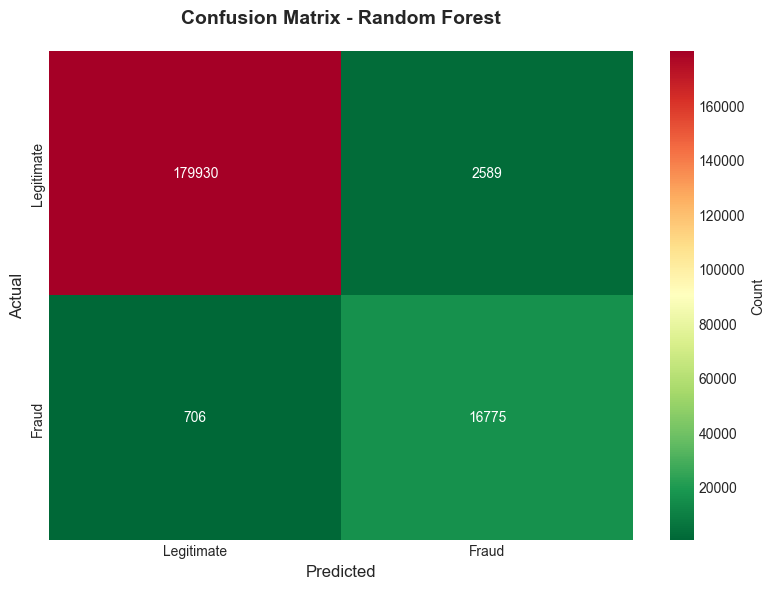

In [24]:
cm = confusion_matrix(y_test, best_predictions)
tn, fp, fn, tp = cm.ravel()

print(f"📊 CONFUSION MATRIX - {best_tuned_model_name}")
print("="*70)
print(f"\n{'':20s} {'Predicted Legitimate':^20s} {'Predicted Fraud':^20s}")
print("-"*70)
print(f"{'Actual Legitimate':20s} {tn:^20d} {fp:^20d}")
print(f"{'Actual Fraud':20s} {fn:^20d} {tp:^20d}")
print("\n" + "="*70)
print("\nInterpretation:")
print(f"  True Negatives (TN):  {tn:6d} - Correctly identified legitimate transactions")
print(f"  False Positives (FP): {fp:6d} - Legitimate transactions flagged as fraud")
print(f"  False Negatives (FN): {fn:6d} - Fraudulent transactions missed")
print(f"  True Positives (TP):  {tp:6d} - Correctly identified fraudulent transactions")

# Calculate rates
print(f"\n{'='*70}")
print("Key Rates:")
print(f"  False Positive Rate: {fp/(fp+tn):.2%} - % of legitimate transactions flagged")
print(f"  False Negative Rate: {fn/(fn+tp):.2%} - % of frauds missed")
print(f"  True Positive Rate:  {tp/(tp+fn):.2%} - % of frauds caught (Recall)")

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', 
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'],
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_tuned_model_name}', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

In [25]:
print(f"CLASSIFICATION REPORT - {best_tuned_model_name}")
print("="*70)
print(classification_report(y_test, best_predictions, target_names=['Legitimate', 'Fraud'], digits=4))

CLASSIFICATION REPORT - Random Forest
              precision    recall  f1-score   support

  Legitimate     0.9961    0.9858    0.9909    182519
       Fraud     0.8663    0.9596    0.9106     17481

    accuracy                         0.9835    200000
   macro avg     0.9312    0.9727    0.9507    200000
weighted avg     0.9847    0.9835    0.9839    200000



In [26]:
import pickle
import joblib
from datetime import datetime

# Create a model package with all necessary components
model_package = {
    'pipeline': best_pipeline,
    'model_name': best_tuned_model_name,
    'feature_names': X_train.columns.tolist(),
    'performance_metrics': {
        'accuracy': tuning_results[best_tuned_model_name]['accuracy'],
        'precision': tuning_results[best_tuned_model_name]['precision'],
        'recall': tuning_results[best_tuned_model_name]['recall'],
        'f1_score': tuning_results[best_tuned_model_name]['f1_score'],
        'roc_auc': tuning_results[best_tuned_model_name]['roc_auc']
    },
    'best_params': tuning_results[best_tuned_model_name]['best_params'],
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'scaler': best_pipeline.named_steps['scaler'],
    'feature_engineer': best_pipeline.named_steps['feature_engineer']
}

# Save using pickle
with open('fraud_detection_model.pkl', 'wb') as file:
    pickle.dump(model_package, file)

# Alternative: Save using joblib (often better for sklearn models)
joblib.dump(model_package, 'fraud_detection_model.joblib')

['fraud_detection_model.joblib']

In [27]:
loaded_model_package = joblib.load('fraud_detection_model.joblib')

print("✅ Model loaded successfully!")
print(f"\nModel name: {loaded_model_package['model_name']}")
print(f"Training date: {loaded_model_package['training_date']}")
print(f"\nFeatures expected: {loaded_model_package['feature_names']}")

# Test prediction
sample_data = X_test.iloc[0:1]
prediction = loaded_model_package['pipeline'].predict(sample_data)
probability = loaded_model_package['pipeline'].predict_proba(sample_data)

print(f"\n{'='*70}")
print("Test Prediction:")
print(f"  Prediction: {'FRAUD' if prediction[0] == 1 else 'LEGITIMATE'}")
print(f"  Probability of Fraud: {probability[0][1]:.2%}")
print(f"  Probability of Legitimate: {probability[0][0]:.2%}")

✅ Model loaded successfully!

Model name: Random Forest
Training date: 2025-11-17 22:31:48

Features expected: ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']

Test Prediction:
  Prediction: LEGITIMATE
  Probability of Fraud: 0.00%
  Probability of Legitimate: 100.00%
